<div class="alert alert-block alert-success">
This jupyter notebook is part of the supplementary material for the book "Materials Data Science" (Stefan Sandfeld, Springer, 2024, DOI 10.1007/978-3-031-46565-9). For further details please refer to the accompanying webpage at <a href="https://mds-book.org">https://mds-book.org</a>.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np


# Copied from listing 12.1
def train_test_split(X, Y, fraction, seed=None):
    """
        Returns a training and a testing dataset (Python Listing 12.1)
        X and Y are numpy arrays with as many rows as samples, fraction (=0..1) defines
        the relative amount of training data, and seed is the initialization of the
        random number generator.
    """


    rng = np.random.default_rng(seed)         # initialize random number generator
    n_total_data = X.shape[0]                 # number of data in the full DS
    n_training = int(fraction * n_total_data) # use fraction of data for training

    indices = np.arange(n_total_data)         # range of integers for indexing X and Y
    
    rng.shuffle(indices)                      # shuffle elements of "indices" in place
    X = X[indices]                            # X and y are shuffled such that each X[i]
    Y = Y[indices]                            # ... is still associated with the same Y[i]

    X_training = X[:n_training]               # use the first "n_training" points for the
    Y_training = Y[:n_training]               # training dataset and ...
    X_testing = X[n_training:]                # the rest of the data for testing.
    Y_testing = Y[n_training:]
    
    return X_training, Y_training, X_testing, Y_testing

# Copied from listing 18.1

def sigmoidal_function(x):
    return 1 / (1 + np.exp(-x))


def forward_pass(W, B, X1, X2):
    (w1, w2, w3, w4, w5, w6),  (b1, b2, b3) = W, B
    
    a1 = b1 + X1 * w1 + X2 * w2
    a2 = b2 + X1 * w3 + X2 * w4
    y1 = sigmoidal_function(a1)
    y2 = sigmoidal_function(a2)
    a3 = y1 * w5 + y2 * w6 + b3
    return a1, a2, y1, y2, a3


def predict(W, B, X1, X2):
    _, _, _, _, Y_pred = forward_pass(W, B, X1, X2)
    return Y_pred


def backward_pass(W, B, X1, X2, Y):
    w1, w2, w3, w4, w5, w6 = W
    a1, a2, y1, y2, a3 = forward_pass(W, B, X1, X2)

    dJdb1 = -(Y - a3) * w5 * y1 * (1 - y1)
    dJdw1 = -(Y - a3) * w5 * y1 * (1 - y1) * X1  # or: dJdw1 = dJdb1 * X1
    dJdw2 = -(Y - a3) * w5 * y1 * (1 - y1) * X2  # or: dJdw2 = dJdb1 * X2
    dJdb2 = -(Y - a3) * w6 * y2 * (1 - y2)
    dJdw3 = -(Y - a3) * w6 * y2 * (1 - y1) * X1  # or: dJdw3 = dJdb2 * X1
    dJdw4 = -(Y - a3) * w6 * y2 * (1 - y1) * X2  # or: dJdw4 = dJdb2 * X2
    dJdb3 = -(Y - a3)
    dJdw5 = -(Y - a3) * y1
    dJdw6 = -(Y - a3) * y2

    dJdW, dJdB = (dJdw1, dJdw2, dJdw3, dJdw4, dJdw5, dJdw6), (dJdb1, dJdb2, dJdb3)
    return dJdW, dJdB


def update_weights(W, B, dJdW, dJdB, learning_rate):
    (w1, w2, w3, w4, w5, w6), (b1, b2, b3) = W, B
    (dJdw1, dJdw2, dJdw3, dJdw4, dJdw5, dJdw6), (dJdb1, dJdb2, dJdb3) = dJdW, dJdB
        
    w1 -= learning_rate * np.mean(dJdw1)
    w2 -= learning_rate * np.mean(dJdw2)
    w3 -= learning_rate * np.mean(dJdw3)
    w4 -= learning_rate * np.mean(dJdw4)
    w5 -= learning_rate * np.mean(dJdw5)
    w6 -= learning_rate * np.mean(dJdw6)
    b1 -= learning_rate * np.mean(dJdb1)
    b2 -= learning_rate * np.mean(dJdb2)
    b3 -= learning_rate * np.mean(dJdb3)

    W_new, B_new = (w1, w2, w3, w4, w5, w6), (b1, b2, b3)
    return W_new, B_new


def mean_loss(Y, Y_pred):
    return 0.5 * np.mean((Y - Y_pred) ** 2)


def train(W, B, X1, X2, Y, epochs, learning_rate):
    mean_losses = []
    
    for epoch in range(epochs):
        Y_pred = predict(W, B, X1, X2)
        mean_losses.append(mean_loss(Y, Y_pred))
        
        dJdW, dJdB = backward_pass(W, B, X1, X2, Y)
        W, B = update_weights(W, B, dJdW, dJdB, learning_rate)

    # also add the updated last value
    Y_pred = predict(W, B, X1, X2)
    mean_losses.append(mean_loss(Y, Y_pred))
    
    return W, B, mean_losses

## 18.3 Backpropagation – Introduction and Example
### 18.3.3 A Complete Python Implementation
We import the data from the package `mdsdata` (see https://mds-book.org/Content/datasets for how to install the package):

In [2]:
import numpy as np
from mdsdata import DS1

iris = DS1.load_data()
X = iris.data[:,:2]
Y = iris.target

# only use the first two labels 0 and 1
X = X[Y < 2]
Y = Y[Y < 2]

... and split the dataset into a set for training and one for testing:

In [3]:
# split into training and testing data
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, fraction=0.6)

# and for convenience define individual features X1 and X2
X1_train = X_train[:, 0]
X2_train = X_train[:, 1]
X1_test = X_test[:, 0]
X2_test = X_test[:, 1]

Next, we initialize the six weights with random values and set the bias values to
zero. The number of epochs (i.e., the number of complete forward/backward passes)
together with the learning rate are set

In [4]:
rng = np.random.default_rng()
W = 1e-3 * (rng.random(size=6) - 0.5)
B = np.zeros(3)
epochs = 600
learning_rate = 0.2

with which now the gradient descent update iterations can be performed:

In [5]:
mean_losses = []
for epoch in range(epochs):
    Y_pred = predict(W, B, X1_train, X2_train)
    mean_losses.append(mean_loss(Y_train, Y_pred))

    dJdW, dJdB = backward_pass(W, B, X1_train, X2_train, Y_train)
    W, B = update_weights(W, B, dJdW, dJdB, learning_rate)
    
print('MSE difference:', mean_losses[0], mean_losses[-1])

MSE difference: 0.22511851173454026 0.015966837732292825


The next plot just shows the training mean
squared error (MSE) as a function of the number of epochs:

[Text(0.5, 0, 'number of epochs'), Text(0, 0.5, 'mean training loss (MSE)')]

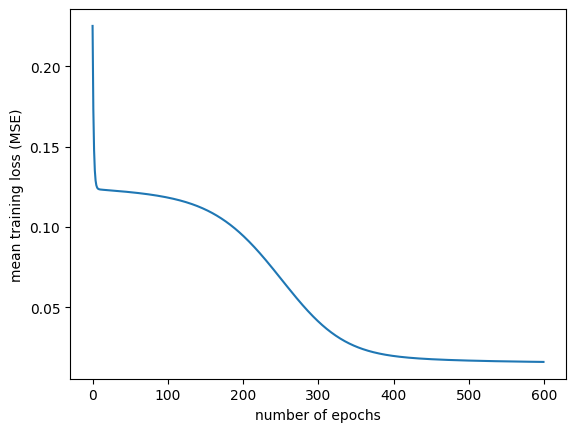

In [6]:
fig, ax = plt.subplots()
ax.plot(mean_losses)
ax.set(xlabel='number of epochs', ylabel='mean training loss (MSE)')

The second plot is a more complex plot. It is a heat map using imshow which shows
the training MSE evaluted at a grid of equidistant points of the feature space. This
was superimposed with a scatter plot of the position of the training and testing data.
Additionally, the decision boundary was shown where all target values smaller than
0.5 indicated class #1 and all values larger than 0.5 indicate class #2.

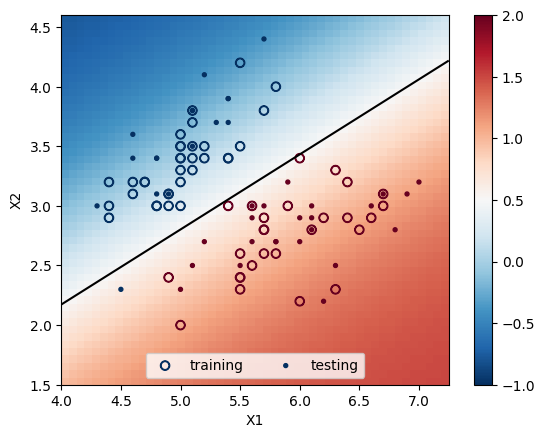

In [7]:
fig, ax = plt.subplots()
ax.set(xlabel='X1', ylabel='X2');

# heatmap with contourplot (showing the decision boundary)
XX1, XX2 = np.meshgrid(np.linspace(4, 7.25), np.linspace(1.5, 4.6))
Y_pred = predict(W, B, XX1, XX2)
im = ax.imshow(Y_pred, origin='lower', vmin=-1, vmax=2, cmap='RdBu_r',
               extent=(XX1.min(), XX1.max(), XX2.min(), XX2.max()))
plt.colorbar(im)
ax.contour(XX1, XX2, Y_pred, levels=[0.5], colors='k')

# scatter plot (marker="$\u25EF$" gives an empty circle)
ax.scatter(X1_train, X2_train, s=45, c=Y_train, cmap='RdBu_r', marker="$\u25EF$", label='training')
ax.scatter(X1_test, X2_test, s=8, c=Y_test, cmap='RdBu_r', marker='o', label='testing')
ax.legend(ncols=2, loc='lower center')

To quantify how well our model performs we evaluate the metric of true positives,
true negatives, false negatives, and false positives, as introduced in Section 11.8.1 of the book. For the testing data we first compute the predictions of the model:

In [8]:
Y_pred = predict(W, B, X1_test, X2_test)

... which then can be compared with the true value `Y_test`:

In [9]:
TP = np.sum((Y_pred > 0.5) & (Y_test > 0.5))
TN = np.sum((Y_pred <= 0.5) & (Y_test <= 0.5))
FP = np.sum((Y_pred > 0.5) & (Y_test <= 0.5))
FN = np.sum((Y_pred <= 0.5) & (Y_test >= 0.5))

print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')

TP: 23, FP: 1, TN: 16, FN: 0
